### First, we'll load in the processed data from the data folder

In [1]:
import numpy as np
import pandas as pd

X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_val = pd.read_csv('../data/X_val.csv')
y_val = pd.read_csv('../data/y_val.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [2]:
X_train

Open      High       Low     Close    Volume  moving_avg_50  \
0   -1.261893 -1.282373 -1.244264 -1.257836 -1.043700            NaN   
1   -1.264133 -1.269703 -1.274461 -1.305309 -0.313123      -1.218345   
2   -1.303205 -1.313705 -1.312510 -1.337888  0.035411      -1.243204   
3   -1.327979 -1.263471 -1.292745 -1.235772  0.181478      -1.262864   
4   -1.231848 -1.231140 -1.210141 -1.203882 -0.035195      -1.245957   
..        ...       ...       ...       ...       ...            ...   
748  1.875767  1.879728  1.880024  1.869527 -0.367313       1.862093   
749  1.867188  1.860309  1.885052  1.865527 -0.313181       1.870502   
750  1.894373  1.889369  1.891904  1.872699 -0.030484       1.878092   
751  1.851855  1.820232  1.762988  1.790303 -0.176766       1.882102   
752  1.793935  1.785319  1.712613  1.735004 -0.417883       1.885578   

     moving_avg_100       Day  Days_to_election  Avg_month_temp  ...  Month_3  \
0               NaN  0.779614          1.000000        0.159902  ...      0.0   
1         -1.177777  0.782369          0.999082        0.159902  ...      0.0   
2         -1.203765  0.785124          0.998163        0.159902  ...      0.0   
3         -1.224317  0.787879          0.997245        0.159902  ...      0.0   
4         -1.206643  0.790634          0.996327        0.159902  ...      0.0   
..              ...       ...               ...             ...  ...      ...   
748        1.817391  0.749311          0.003673       -0.082026  ...      0.0   
749        1.824953  0.752066          0.002755       -0.082026  ...      0.0   
750        1.832419  0.754821          0.001837       -0.082026  ...      0.0   
751        1.838891  0.757576          0.000918       -0.082026  ...      0.0   
752        1.845464  0.760331          0.000000       -0.082026  ...      0.0   

     Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
0        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
1        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
2        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
3        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
4        0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
..       ...      ...      ...      ...      ...      ...       ...       ...   
748      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
749      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
750      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
751      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
752      0.0      0.0      0.0      0.0      0.0      0.0       1.0       0.0   

     Month_12  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
..        ...  
748       0.0  
749       0.0  
750       0.0  
751       0.0  
752       0.0  

[753 rows x 25 columns]

## Processing: 14-day sliding prediction window
***Our model will predict values of our target variable by considering the past two weeks' data at any time. In order to do this, we will transform the stucture of our data such that each row includes a given day's feature values, as well as the values for each of the 14 preceeding days. We will also include the past values of the target variable in this window because after a day has passed, the target variable's value on that day can be treated as known.***

In [3]:
# each column will have a '_i' at the end of its name indicating
# its delay (i.e. the present day will end in '_0' and the values
# from two weeks ago will have '_14' at the end).

def get_lagged_df(df, delay):
    '''function to take in a dataframe return a df with lagged columns'''
    # list for all of the shifted df copies that we'll concat into the df
    values = []
    # shift by value i=0,...,delay so we have the original day's value
    # as well as its window
    for i in range(delay+1):
        values.append(df.shift(i).copy())
        values[-1].columns = [col + '_' + str(i) for col in df.columns]
    return pd.concat(values, axis=1)

In [4]:
# now lets go through our target variable and grab the lagged values for that
# --> just as in the previous method we'll add on target variable columns for
# delays i=1,...,14 (not 0 because we aren't allowed to see the current day's
# target value)

# function will take in the df we're editing along with the corresponding
# target variable series y

def get_lagged_y(df, y, delay):
    '''take in lagged feature matrix, attach lagged y values'''
    for i in range(delay):
        df['y_'+str(i+1)] = y.shift(i+1)
    return df

In [5]:
# function to combine the two lagging methods and spit out our data in the form 
# in which we can feed it to a regression model

def get_timeseries_df(df, y, delay):
    '''wrapper method to do both steps in one call'''
    df = get_lagged_df(df, delay)
    df = get_lagged_y(df, y, delay)
    return df

### Now we can transform our data to be windowed for 14-day sliding time series window

In [66]:
# generating the datasets
X_train_windowed = get_timeseries_df(X_train, y_train, 14)
X_val_windowed = get_timeseries_df(X_val, y_val, 14)
X_test_windowed = get_timeseries_df(X_test, y_test, 14)

In [68]:
# check for current day features that give us unfair information about the adj. close price
# i.e. get rid of any current day information that wouldn't be available at market open
for col in X_train_windowed.columns:
    if col.endswith('_0'):
        print(col)

Open_0
High_0
Low_0
Close_0
Volume_0
moving_avg_50_0
moving_avg_100_0
Day_0
Days_to_election_0
Avg_month_temp_0
Avg_month_temp_dev_0
CCI_0
VIXCLS_0
Month_1_0
Month_2_0
Month_3_0
Month_4_0
Month_5_0
Month_6_0
Month_7_0
Month_8_0
Month_9_0
Month_10_0
Month_11_0
Month_12_0


In [69]:
# From the check above, will get rid of all non-date features expect for Open_0
cols_to_remv = ['High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0',
               'moving_avg_100_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0',
               'CCI_0', 'VIXCLS_0']
X_train_windowed.drop(columns=cols_to_remv, inplace=True)
X_val_windowed.drop(columns=cols_to_remv, inplace=True)
X_test_windowed.drop(columns=cols_to_remv, inplace=True)

In [70]:
# ... and saving them to our data folder
X_train_windowed.to_csv('../data/X_train_windowed.csv', index=False)
X_val_windowed.to_csv('../data/X_val_windowed.csv', index=False)
X_test_windowed.to_csv('../data/X_test_windowed.csv', index=False)

## Random Forest Regressor

***With a random forest we can't extrapolate to unseen target values so we're flatlining in the sections of training data with target values that surpass what was seen in the training and validation steps. To get around this we will change the target variable for the random forest to percent change from one day to the next, and use these values/predictions to reconstruct the adjusted close price values***

-----

***With a random forest we need to drop the missing values, so we'll get rid of the first 14 rows in our data sets***

In [71]:
# drop rows with missing values
X_train_rf = X_train_windowed.dropna()
# get the y values for the corresponding data points
y_train_rf = y_train.iloc[X_train_rf.index]

X_val_rf = X_val_windowed.dropna()
y_val_rf = y_val.iloc[X_val_rf.index]

X_test_rf = X_test_windowed.dropna()
y_test_rf = y_test.iloc[X_test_rf.index]

## Implementation of a persistence model -- this isn't our baseline model but we'll use it time to time for comparison against a naive prediction moel
### ***(Baseline should just be a prediction of the mean y value)***
***This model just predicts the the target value at $t-1$ for $t$, and we'll use RMSE as our metic***

*Below we get a run a quick example on our training data*

In [11]:
# our baseline model that will predict that the value at any time step
# will persist to the next time step

# it just returns the first 1,...,n-1 values of the target variable
# but these are its predictions for times 2,...,n (we won't have a
# prediction for time t=1 under this model)
def persistence_predict(target_series):
    '''function to make the baseline prediction'''
    return target_series[:-1]

# and we can get the RMSE by comparing this to the target values at
# t = 2,...,n
from sklearn.metrics import mean_squared_error

y_persistence_pred = persistence_predict(y_train_rf)
persistence_rmse = mean_squared_error(y_train_rf[1:], y_persistence_pred, squared=False)

print('Baseline persistence model RMSE on the test data = ',str(persistence_rmse))

Baseline persistence model RMSE on the test data =  17.348538610020732


In [12]:
# # ... and a quick sanity-check comparison against our untuned RF from above
# y_untuned_rf_pred = rf.predict(X_train_rf)

# untuned_train_rmse = mean_squared_error(y_train_rf, y_untuned_rf_pred, squared=False)

# print('Untuned RF RMSE on the test data = ',str(untuned_train_rmse))

## General hyperparameter tuning method
***Our data has already been split and processed by this point, so this is a method that will take in the split and processed data, a model, and a parameter grid***

In [13]:
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

def ML_pipe_RMSE(X_train, y_train, X_val, y_val, ML_algo, param_grid):
    '''Hyperparameter tuning method to take in the processed data, model, 
    and parameter grid to be swept over -- we minimize RMSE as our metric'''
        
    # because our data is a time series, we need to preserve the split
    # as it's prepared above --> we'll give GridSearchCV a predefined split
    x = np.concatenate([X_train_rf, X_val_rf])
    y = np.concatenate([y_train_rf, y_val_rf])

    test_fold = np.concatenate([
        # The training data.
        np.full(X_train_rf.shape[1], -1, dtype=np.int8),
        # The validation data.
        np.zeros(X_val_rf.shape[1], dtype=np.int8)])
    cv = PredefinedSplit(test_fold)

    grid = GridSearchCV(estimator=ML_algo, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                        cv=cv, return_train_score=True, n_jobs=-1, verbose=False)

    grid.fit(x, y.ravel())
    results = pd.DataFrame(grid.cv_results_)
    # print(results)

    # find which hyperparameter combination gives the best validation score (1 point)
    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations

    # get the best model from the parameter grid
    best_model = grid.best_estimator_

    # calculate the test score
    y_val_pred = best_model.predict(X_val)
    test_score = mean_squared_error(y_val, y_val_pred, squared=False)
        
    return best_model, test_score

## Hyperparameter Tuning: Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

# we also need to fix the model's random state here because random forests
# are not deterministic (as one would guess from the name)
ML_algo_RF = RandomForestRegressor(random_state=42)
param_grid = {'max_depth': [i for i in range(10,350,20)],
               # the max_depth should be smaller or equal than the number of features roughly
               # ---> num_features = 10 in the diabetes dataset
              'max_features': [0.5,0.6,0.7,0.8,0.9,1.0]} 
              # linearly spaced between 0.5 and 1
model_RF, score_RF = ML_pipe_RMSE(X_train_rf,
                            y_train_rf, 
                            X_val_rf, 
                            y_val_rf, 
                            ML_algo_RF, 
                            param_grid)
print('Val score: ',score_RF)

best model parameters: {'max_depth': 10, 'max_features': 0.5}
validation score: -321.17722320477486
Val score:  9.510845386989372


In [73]:
y_tuned_rf_pred = model_RF.predict(X_test_rf)

tuned_test_rmse = mean_squared_error(y_test_rf, y_tuned_rf_pred, squared=False)

print('Tuned RF RMSE on the test data = ',str(tuned_test_rmse))

Tuned RF RMSE on the test data =  245.99508159148843


In [74]:
# checking the R2 value:
model_RF.score(X_val_rf, y_val_rf) #<--- 0.9999, okay something is clearly broken

0.9954848521226903

In [75]:
# just going to feed a few rows into a linear regressor and see which
# coefficient is taking all the weight
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_rf[:500], y_train_rf[:500])
print(reg.score(X_train_rf[:500], y_train_rf[:500]))
print(reg.coef_)
coefs = reg.coef_[0]
for i in range(len(coefs)):
    if np.abs(coefs[i]) > 10:
        print(X_train_rf.columns[i])

0.9985856413707875
[[ 4.87501928e+02 -7.70593149e+01 -2.23120378e+02 -3.79639222e+01
  -4.57167603e+01 -4.14079391e+01 -2.44640775e+01 -7.85941695e+00
  -2.88496139e+00  1.57802351e+01  1.79801453e+01  1.29154453e+01
   2.55482019e+01  3.87835201e+01  4.92895298e+01 -2.13510117e+01
  -1.58517392e+00  9.66799811e+01 -4.16337667e-03 -5.59420033e-01
   2.23024239e+02  2.02276869e+02  6.03341900e+01 -5.84999572e+02
  -1.43831404e+00  3.73714846e+00  1.70852482e+01 -9.10255302e+00
   5.87006359e+01  3.98512823e+01  3.51482243e+01  3.20964823e+01
   2.09859502e+01  2.40303911e+01  1.65451263e+00 -1.26425322e+01
  -1.89668334e-01 -5.73511400e+01 -7.33962560e+01 -6.88878821e+01
   4.17307658e+01  1.04806756e+02  2.14671915e+01 -1.43758467e-03
  -2.21617232e+00  3.63369725e+02  1.78522780e+03 -4.31440700e+01
   2.07287264e+03 -1.81390230e+01 -5.10315291e+00 -2.66801656e+01
  -3.59175051e+00 -5.99228354e+01 -2.84984060e+01 -2.39912035e+01
  -2.82863599e+01 -2.70072063e+01 -2.46135234e+01 -6.9367

In [77]:
X_train_rf.columns

Index(['Open_0', 'Day_0', 'Days_to_election_0', 'Month_1_0', 'Month_2_0',
       'Month_3_0', 'Month_4_0', 'Month_5_0', 'Month_6_0', 'Month_7_0',
       ...
       'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13',
       'y_14'],
      dtype='object', length=379)

***Plotting the prediction over the three sets of data***

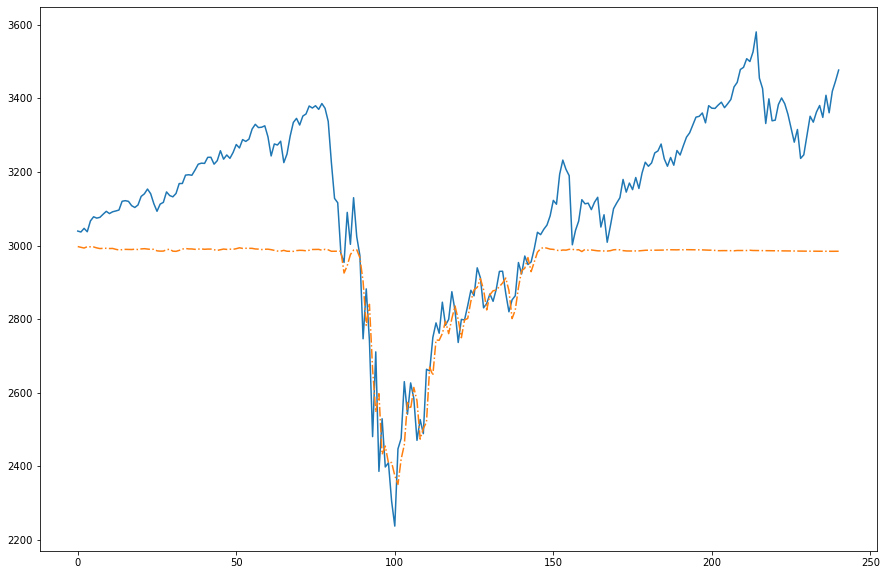

In [78]:
import matplotlib.pyplot as plt

# get our random forest's prediction over the training period
training_predictions = model_RF.predict(X_train_rf)

# plt.plot(range(len(y_train_rf)), y_train_rf, '-')
# plt.plot(range(len(training_predictions)), training_predictions, '.')
# plt.show()

validation_predictions = model_RF.predict(X_val_rf)

# plt.plot(range(len(y_val_rf)), y_val_rf, '-')
# plt.plot(range(len(validation_predictions)), validation_predictions, '.')
# plt.show()

testing_predictions = model_RF.predict(X_test_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_test_rf)), y_test_rf, '-')
plt.plot(range(len(testing_predictions)), testing_predictions, '-.')
plt.show()

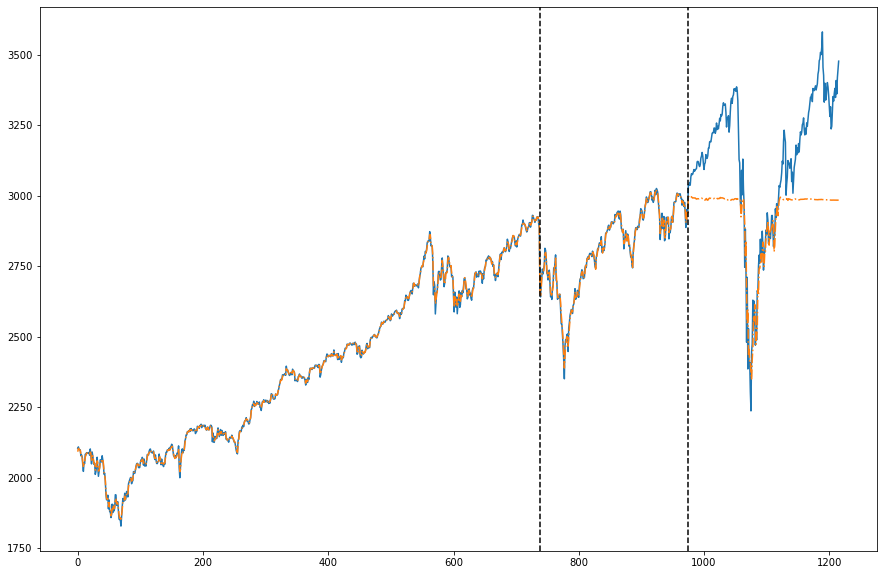

In [79]:
predictions = np.concatenate([training_predictions, 
                         validation_predictions,
                         testing_predictions])

true_series = np.concatenate([y_train_rf,
                                y_val_rf,
                                y_test_rf])

plt.figure(figsize = (15,10))
plt.plot(range(len(true_series)), true_series, '-')
plt.plot(range(len(predictions)), predictions, '-.')
# vertical lines separating the training data from the valiation
# from the testing data
plt.axvline(x=len(y_train_rf), color='k', linestyle='--')
plt.axvline(x=len(y_train_rf)+len(y_val_rf), color='k', linestyle='--')
plt.show()

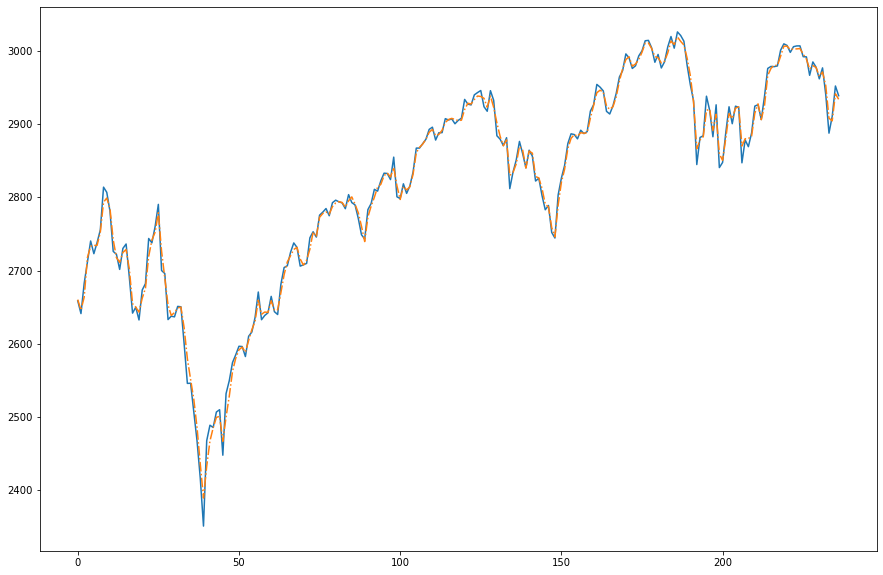

In [81]:
val_pred = model_RF.predict(X_val_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_val_rf)), y_val_rf, '-')
plt.plot(range(len(val_pred)), val_pred, '-.')
plt.show()

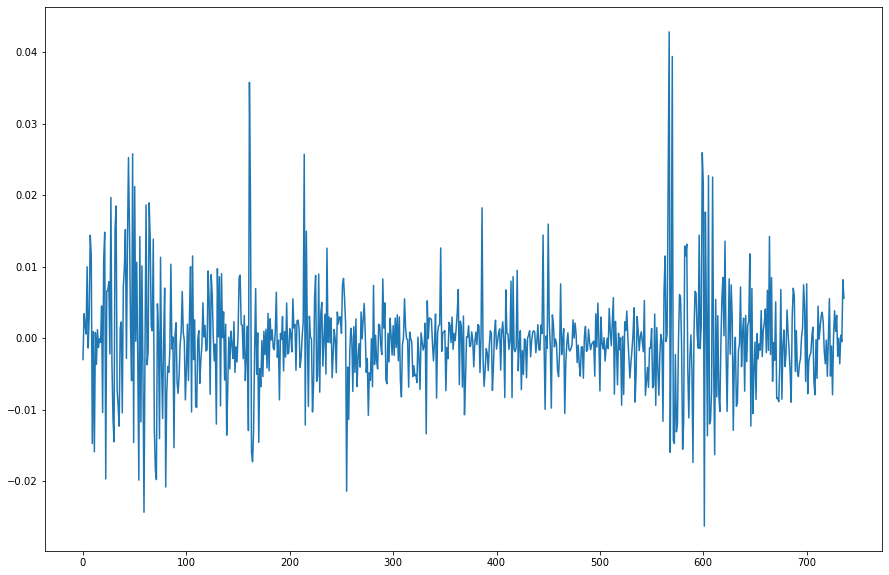

In [87]:
# plotting percent daily error
err = [float(i - j) for i, j in zip(training_predictions, np.array(y_train_rf[1:]))]
pct_err = [float(i / j) for i, j in zip(err, np.array(y_train_rf[1:]))] 

plt.figure(figsize=(15,10))
plt.plot(pct_err)
plt.show()

In [91]:
# RMSE for persistence model and for the tuned model

y_baseline_pred = persistence_predict(y_train_rf)
baseline_rmse = mean_squared_error(y_train_rf[1:], y_baseline_pred, squared=False)

print('Baseline persistence model RMSE on the training data = ',str(baseline_rmse))

tuned_train_rmse = mean_squared_error(y_train_rf, training_predictions, squared=False)

print('Tuned RF RMSE on the training data = ',str(tuned_train_rmse))

Baseline persistence model RMSE on the training data =  17.348538610020732
Tuned RF RMSE on the training data =  1.3035616127364125


------

## Hyperparameter Tuning: SVR
# ***SVR is deterministic, right? i.e. no need to set random state?***

In [44]:
from sklearn.svm import SVR

# don't need to fix a random state because SVR is deterministic for any set
# of parameters and data
ML_algo_SVR = SVR()
param_grid = {'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
             # --> from week 7 module we know gamma should be logspaced
             'C': [0.1, 1, 10, 100]}
             # ---> and we'll logspace space C from 0.1 to 100
# we use the rf datasets because we also need to drop missing values
# for svr -- that wasn't the most informative naming
model_SVR, score_SVR = ML_pipe_RMSE(X_train_rf,
                            y_train_rf, 
                            X_val_rf, 
                            y_val_rf, 
                            ML_algo_SVR, 
                            param_grid)
print('Val score: ',score_SVR)

best model parameters: {'C': 10, 'gamma': 0.0001}
validation score: -522.9828252498171
Val score:  207.95838351625633


In [34]:
y_tuned_svr_pred = model_SVR.predict(X_test_rf)

tuned_test_rmse_SVR = mean_squared_error(y_test_rf, y_tuned_svr_pred, squared=False)

print('Tuned RF RMSE on the test data = ',str(tuned_test_rmse_SVR))

Tuned RF RMSE on the test data =  608.4695198774155


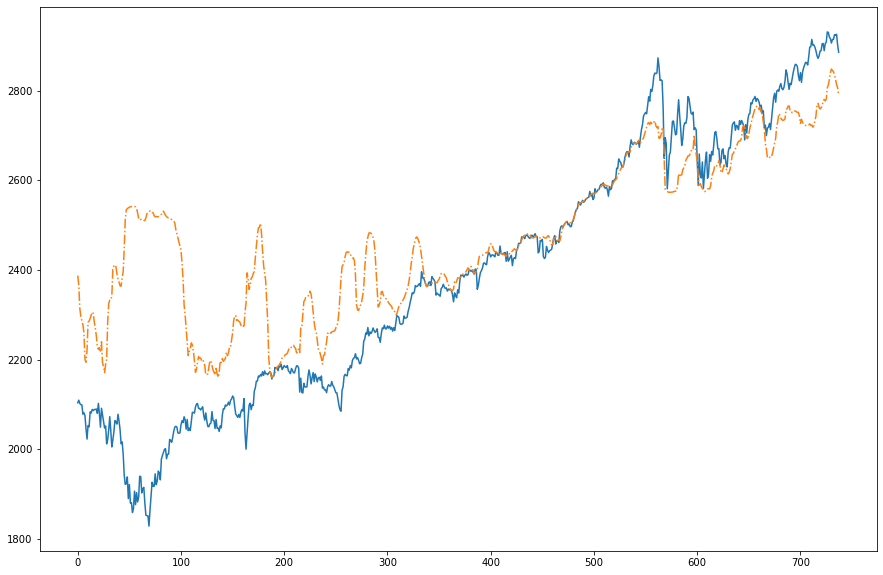

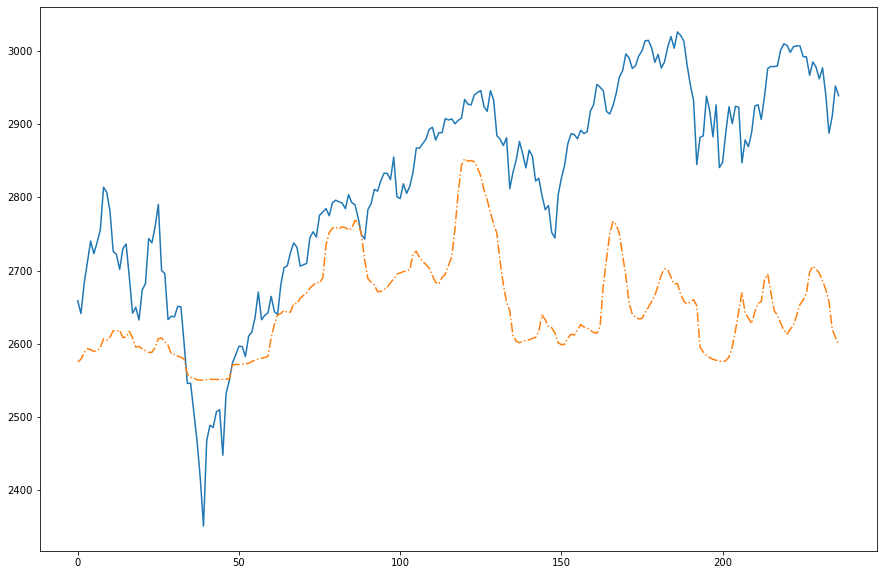

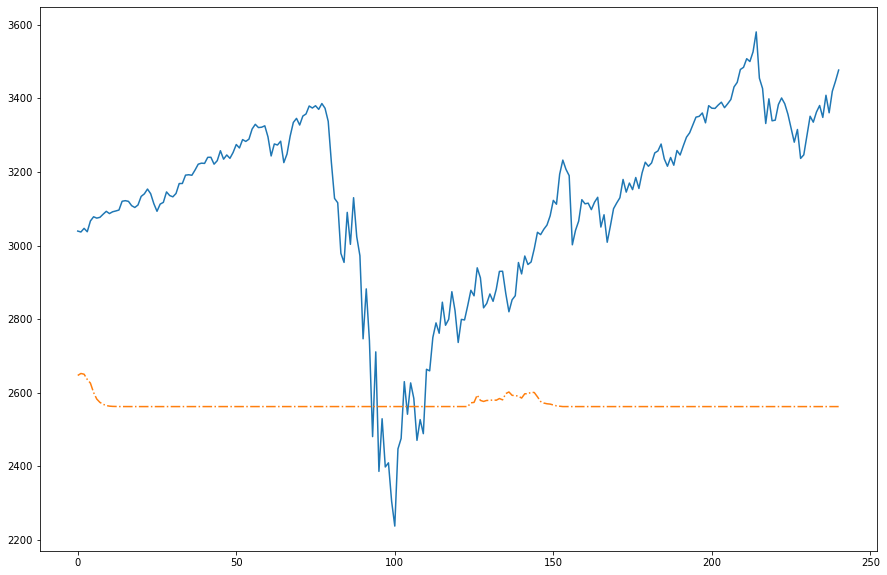

In [37]:
# get our random forest's prediction over the training period
train_pred_svr = model_SVR.predict(X_train_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_train_rf)), y_train_rf, '-')
plt.plot(range(len(train_pred_svr)), train_pred_svr, '-.')
plt.show()

val_pred_svr = model_SVR.predict(X_val_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_val_rf)), y_val_rf, '-')
plt.plot(range(len(val_pred_svr)), val_pred_svr, '-.')
plt.show()

test_pred_svr = model_SVR.predict(X_test_rf)
plt.figure(figsize = (15,10))
plt.plot(range(len(y_test_rf)), y_test_rf, '-')
plt.plot(range(len(test_pred_svr)), test_pred_svr, '-.')
plt.show()

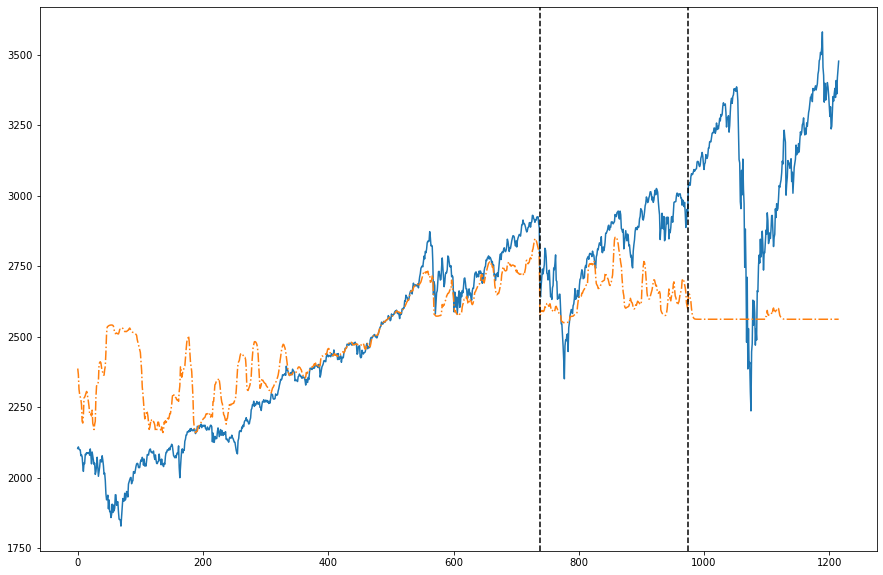

In [38]:
predictions_SVR = np.concatenate([train_pred_svr, 
                                 val_pred_svr,
                                 test_pred_svr])

# true_series = np.concatenate([y_train_rf,
#                                 y_val_rf,
#                                 y_test_rf])

plt.figure(figsize = (15,10))
plt.plot(range(len(true_series)), true_series, '-')
plt.plot(range(len(predictions_SVR)), predictions_SVR, '-.')
# vertical lines separating the training data from the valiation
# from the testing data
plt.axvline(x=len(y_train_rf), color='k', linestyle='--')
plt.axvline(x=len(y_train_rf)+len(y_val_rf), color='k', linestyle='--')
plt.show()

## Hyperparameter Tuning: XGBoost

In [48]:
y_train

Adj Close
0    2017.459961
1    2003.689941
2    1994.239990
3    2023.859985
4    2033.109985
..           ...
748  2924.590088
749  2923.429932
750  2925.510010
751  2901.610107
752  2885.570068

[753 rows x 1 columns]

In [50]:
import xgboost

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss

# we also need to fix the model's random state here because random forests
# are not deterministic (as one would guess from the name)
ML_algo_XGB = xgboost.XGBRegressor()
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

model_XGB, score_XGB = ML_pipe_RMSE(X_train_windowed,
                                    y_train, 
                                    X_val_windowed, 
                                    y_val, 
                                    ML_algo_XGB, 
                                    param_grid)
print('Val score: ',score_XGB)

best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.66}
validation score: -293.8726564807449


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388'] ['Open_0', 'High_0', 'Low_0', 'Close_0', 'Volume_0', 'moving_avg_50_0', 'moving_avg_100_0', 'Day_0', 'Days_to_election_0', 'Avg_month_temp_0', 'Avg_month_temp_dev_0', 'CCI_0', 'VIXCLS_0', 'Month_1_0', 'Month_2_0', 'Month_3_0', 'Month_4_0', 'Month_5_0', 'Month_6_0', 'Month_7_0', 'Month_8_0', 'Month_9_0', 'Month_10_0', 'Month_11_0', 'Month_12_0', 'Open_1', 'High_1', 'Low_1', 'Close_1', 'Volume_1', 'moving_avg_50_1', 'moving_avg_100_1', 'Day_1', 'Days_to_election_1', 'Avg_month_temp_1', 'Avg_month_temp_dev_1', 'CCI_1', 'VIXCLS_1', 'Month_1_1', 'Month_2_1', 'Month_3_1', 'Month_4_1', 'Month_5_1', 'Month_6_1', 'Month_7_1', 'Month_8_1', 'Month_9_1', 'Month_10_1', 'Month_11_1', 'Month_12_1', 'Open_2', 'High_2', 'Low_2', 'Close_2', 'Volume_2', 'moving_avg_50_2', 'moving_avg_100_2', 'Day_2', 'Days_to_election_2', 'Avg_month_temp_2', 'Avg_month_temp_dev_2', 'CCI_2', 'VIXCLS_2', 'Month_1_2', 'Month_2_2', 'Month_3_2', 'Month_4_2', 'Month_5_2', 'Month_6_2', 'Month_7_2', 'Month_8_2', 'Month_9_2', 'Month_10_2', 'Month_11_2', 'Month_12_2', 'Open_3', 'High_3', 'Low_3', 'Close_3', 'Volume_3', 'moving_avg_50_3', 'moving_avg_100_3', 'Day_3', 'Days_to_election_3', 'Avg_month_temp_3', 'Avg_month_temp_dev_3', 'CCI_3', 'VIXCLS_3', 'Month_1_3', 'Month_2_3', 'Month_3_3', 'Month_4_3', 'Month_5_3', 'Month_6_3', 'Month_7_3', 'Month_8_3', 'Month_9_3', 'Month_10_3', 'Month_11_3', 'Month_12_3', 'Open_4', 'High_4', 'Low_4', 'Close_4', 'Volume_4', 'moving_avg_50_4', 'moving_avg_100_4', 'Day_4', 'Days_to_election_4', 'Avg_month_temp_4', 'Avg_month_temp_dev_4', 'CCI_4', 'VIXCLS_4', 'Month_1_4', 'Month_2_4', 'Month_3_4', 'Month_4_4', 'Month_5_4', 'Month_6_4', 'Month_7_4', 'Month_8_4', 'Month_9_4', 'Month_10_4', 'Month_11_4', 'Month_12_4', 'Open_5', 'High_5', 'Low_5', 'Close_5', 'Volume_5', 'moving_avg_50_5', 'moving_avg_100_5', 'Day_5', 'Days_to_election_5', 'Avg_month_temp_5', 'Avg_month_temp_dev_5', 'CCI_5', 'VIXCLS_5', 'Month_1_5', 'Month_2_5', 'Month_3_5', 'Month_4_5', 'Month_5_5', 'Month_6_5', 'Month_7_5', 'Month_8_5', 'Month_9_5', 'Month_10_5', 'Month_11_5', 'Month_12_5', 'Open_6', 'High_6', 'Low_6', 'Close_6', 'Volume_6', 'moving_avg_50_6', 'moving_avg_100_6', 'Day_6', 'Days_to_election_6', 'Avg_month_temp_6', 'Avg_month_temp_dev_6', 'CCI_6', 'VIXCLS_6', 'Month_1_6', 'Month_2_6', 'Month_3_6', 'Month_4_6', 'Month_5_6', 'Month_6_6', 'Month_7_6', 'Month_8_6', 'Month_9_6', 'Month_10_6', 'Month_11_6', 'Month_12_6', 'Open_7', 'High_7', 'Low_7', 'Close_7', 'Volume_7', 'moving_avg_50_7', 'moving_avg_100_7', 'Day_7', 'Days_to_election_7', 'Avg_month_temp_7', 'Avg_month_temp_dev_7', 'CCI_7', 'VIXCLS_7', 'Month_1_7', 'Month_2_7', 'Month_3_7', 'Month_4_7', 'Month_5_7', 'Month_6_7', 'Month_7_7', 'Month_8_7', 'Month_9_7', 'Month_10_7', 'Month_11_7', 'Month_12_7', 'Open_8', 'High_8', 'Low_8', 'Close_8', 'Volume_8', 'moving_avg_50_8', 'moving_avg_100_8', 'Day_8', 'Days_to_election_8', 'Avg_month_temp_8', 'Avg_month_temp_dev_8', 'CCI_8', 'VIXCLS_8', 'Month_1_8', 'Month_2_8', 'Month_3_8', 'Month_4_8', 'Month_5_8', 'Month_6_8', 'Month_7_8', 'Month_8_8', 'Month_9_8', 'Month_10_8', 'Month_11_8', 'Month_12_8', 'Open_9', 'High_9', 'Low_9', 'Close_9', 'Volume_9', 'moving_avg_50_9', 'moving_avg_100_9', 'Day_9', 'Days_to_election_9', 'Avg_month_temp_9', 'Avg_month_temp_dev_9', 'CCI_9', 'VIXCLS_9', 'Month_1_9', 'Month_2_9', 'Month_3_9', 'Month_4_9', 'Month_5_9', 'Month_6_9', 'Month_7_9', 'Month_8_9', 'Month_9_9', 'Month_10_9', 'Month_11_9', 'Month_12_9', 'Open_10', 'High_10', 'Low_10', 'Close_10', 'Volume_10', 'moving_avg_50_10', 'moving_avg_100_10', 'Day_10', 'Days_to_election_10', 'Avg_month_temp_10', 'Avg_month_temp_dev_10', 'CCI_10', 'VIXCLS_10', 'Month_1_10', 'Month_2_10', 'Month_3_10', 'Month_4_10', 'Month_5_10', 'Month_6_10', 'Month_7_10', 'Month_8_10', 'Month_9_10', 'Month_10_10', 'Month_11_10', 'Month_12_10', 'Open_11', 'High_11', 'Low_11', 'Close_11', 'Volume_11', 'moving_avg_50_11', 'moving_avg_100_11', 'Day_11', 'Days_to_election_11', 'Avg_month_temp_11', 'Avg_month_temp_dev_11', 'CCI_11', 'VIXCLS_11', 'Month_1_11', 'Month_2_11', 'Month_3_11', 'Month_4_11', 'Month_5_11', 'Month_6_11', 'Month_7_11', 'Month_8_11', 'Month_9_11', 'Month_10_11', 'Month_11_11', 'Month_12_11', 'Open_12', 'High_12', 'Low_12', 'Close_12', 'Volume_12', 'moving_avg_50_12', 'moving_avg_100_12', 'Day_12', 'Days_to_election_12', 'Avg_month_temp_12', 'Avg_month_temp_dev_12', 'CCI_12', 'VIXCLS_12', 'Month_1_12', 'Month_2_12', 'Month_3_12', 'Month_4_12', 'Month_5_12', 'Month_6_12', 'Month_7_12', 'Month_8_12', 'Month_9_12', 'Month_10_12', 'Month_11_12', 'Month_12_12', 'Open_13', 'High_13', 'Low_13', 'Close_13', 'Volume_13', 'moving_avg_50_13', 'moving_avg_100_13', 'Day_13', 'Days_to_election_13', 'Avg_month_temp_13', 'Avg_month_temp_dev_13', 'CCI_13', 'VIXCLS_13', 'Month_1_13', 'Month_2_13', 'Month_3_13', 'Month_4_13', 'Month_5_13', 'Month_6_13', 'Month_7_13', 'Month_8_13', 'Month_9_13', 'Month_10_13', 'Month_11_13', 'Month_12_13', 'Open_14', 'High_14', 'Low_14', 'Close_14', 'Volume_14', 'moving_avg_50_14', 'moving_avg_100_14', 'Day_14', 'Days_to_election_14', 'Avg_month_temp_14', 'Avg_month_temp_dev_14', 'CCI_14', 'VIXCLS_14', 'Month_1_14', 'Month_2_14', 'Month_3_14', 'Month_4_14', 'Month_5_14', 'Month_6_14', 'Month_7_14', 'Month_8_14', 'Month_9_14', 'Month_10_14', 'Month_11_14', 'Month_12_14', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14']
expected f107, f212, f180, f379, f272, f377, f203, f358, f213, f309, f158, f93, f21, f112, f5, f174, f196, f13, f77, f276, f326, f102, f281, f300, f262, f280, f89, f67, f292, f148, f216, f312, f42, f46, f151, f375, f301, f350, f25, f57, f275, f322, f75, f320, f56, f173, f157, f159, f225, f104, f12, f183, f4, f6, f330, f74, f175, f120, f97, f96, f135, f205, f83, f361, f188, f68, f111, f359, f62, f373, f316, f105, f87, f31, f2, f278, f164, f382, f387, f201, f215, f208, f177, f240, f124, f238, f141, f233, f388, f139, f257, f228, f128, f190, f86, f318, f250, f206, f193, f345, f22, f64, f58, f161, f236, f149, f343, f246, f218, f298, f342, f229, f36, f136, f176, f289, f324, f55, f134, f33, f252, f244, f232, f207, f14, f94, f72, f266, f279, f70, f99, f302, f214, f293, f185, f337, f356, f231, f23, f117, f264, f365, f222, f209, f226, f263, f166, f255, f386, f199, f145, f369, f204, f355, f115, f54, f170, f3, f230, f273, f198, f311, f119, f364, f378, f181, f287, f245, f131, f143, f306, f16, f372, f371, f138, f340, f179, f286, f384, f254, f308, f34, f50, f224, f27, f35, f328, f197, f329, f109, f61, f288, f353, f249, f90, f44, f127, f133, f331, f321, f106, f39, f81, f344, f155, f366, f304, f294, f210, f334, f376, f368, f49, f242, f385, f91, f65, f200, f10, f19, f30, f147, f41, f146, f156, f248, f121, f346, f108, f284, f367, f223, f374, f40, f347, f1, f381, f20, f122, f221, f59, f52, f150, f296, f92, f162, f370, f319, f178, f154, f354, f282, f71, f100, f220, f194, f48, f101, f51, f167, f85, f26, f357, f195, f327, f268, f299, f259, f383, f95, f114, f116, f189, f191, f332, f47, f239, f243, f82, f38, f247, f79, f184, f43, f227, f303, f351, f333, f363, f285, f336, f274, f325, f202, f11, f53, f277, f15, f153, f348, f265, f123, f317, f256, f271, f24, f380, f217, f37, f69, f9, f219, f237, f362, f283, f305, f253, f295, f140, f192, f88, f126, f45, f144, f235, f113, f261, f80, f137, f78, f0, f168, f260, f339, f28, f84, f234, f17, f7, f352, f315, f63, f313, f32, f73, f171, f307, f152, f182, f186, f163, f8, f211, f241, f338, f103, f341, f98, f76, f169, f18, f66, f160, f270, f349, f291, f290, f335, f142, f125, f267, f297, f110, f258, f29, f187, f130, f310, f165, f60, f172, f269, f323, f251, f129, f132, f118, f314, f360 in input data
training data did not have the following fields: Volume_2, y_8, moving_avg_50_8, Day_9, Month_2_1, Avg_month_temp_9, Day_13, moving_avg_50_2, Days_to_election_2, Month_11_14, Open_7, Avg_month_temp_13, moving_avg_50_7, Month_1_5, Month_9_12, Month_10_9, VIXCLS_11, Avg_month_temp_dev_8, Month_7_10, Volume_8, y_1, Month_3_4, Open_3, Month_1_4, Month_5_14, Month_5_5, Day_0, Close_6, High_4, Month_8_3, Month_12_6, Month_6_14, Month_5_2, VIXCLS_5, Avg_month_temp_dev_2, Avg_month_temp_2, High_14, Days_to_election_12, Month_11_6, Month_2_7, VIXCLS_7, moving_avg_100_3, High_2, Month_1_1, Avg_month_temp_3, Month_11_8, Month_5_1, Open_1, Low_10, Month_3_8, Month_3_12, Close_5, Month_9_14, moving_avg_100_0, Day_8, Month_2_9, Avg_month_temp_1, Volume_9, Open_11, moving_avg_100_12, Month_1_14, Month_3_6, Month_8_2, Close_2, moving_avg_100_11, moving_avg_50_14, moving_avg_50_5, Low_13, Month_12_13, Month_11_4, y_10, Low_1, Month_10_14, Volume_0, Month_10_4, Month_5_7, Month_8_8, Close_10, Avg_month_temp_5, Day_14, Month_6_12, Month_8_5, moving_avg_100_4, Days_to_election_3, Month_5_0, Month_8_4, Month_3_5, Open_2, moving_avg_100_5, CCI_10, Avg_month_temp_12, Month_11_12, Month_3_9, Month_4_13, Month_12_11, Month_10_8, moving_avg_100_8, Month_9_13, CCI_0, Month_6_2, Month_9_4, Volume_3, y_11, Low_8, Month_9_10, Month_5_3, Month_9_0, Month_4_5, Month_7_11, Close_7, Avg_month_temp_dev_11, Month_5_11, Month_9_2, Month_6_1, High_11, Volume_7, Volume_12, Month_10_1, Month_7_2, Month_12_12, Month_3_1, Close_0, VIXCLS_3, Low_11, High_1, Month_5_12, CCI_11, moving_avg_50_11, Month_5_13, Days_to_election_4, Low_9, Month_11_3, Month_9_11, VIXCLS_6, Month_10_5, Month_9_8, Days_to_election_9, Month_2_13, Month_6_11, Days_to_election_5, Month_10_3, High_12, Avg_month_temp_4, Avg_month_temp_8, Days_to_election_1, VIXCLS_4, Month_6_4, Month_12_8, Month_7_4, moving_avg_100_1, Month_6_7, Month_4_4, Volume_11, y_3, Days_to_election_10, Month_10_0, Day_6, Month_1_10, Month_2_0, Month_10_11, Volume_10, Day_2, Avg_month_temp_dev_4, Month_10_7, y_2, Month_10_13, Month_8_9, Month_4_7, VIXCLS_9, Month_3_2, Month_3_14, Month_11_9, High_10, moving_avg_50_12, Month_7_14, Low_7, Avg_month_temp_dev_6, Low_3, CCI_2, Day_11, Month_3_10, Month_9_5, Days_to_election_13, Month_12_2, Open_6, Avg_month_temp_dev_0, CCI_9, Open_13, Month_7_13, Avg_month_temp_dev_1, Month_7_6, Month_8_10, y_7, Volume_5, Month_1_7, Month_11_1, Month_5_9, moving_avg_100_7, Day_3, Volume_6, Days_to_election_8, Open_9, Close_13, High_5, Month_1_8, y_6, moving_avg_100_9, Avg_month_temp_dev_9, Month_7_1, Month_3_7, Month_10_10, Month_8_12, Month_8_1, Month_4_3, Month_4_8, Month_2_14, Month_9_1, CCI_12, moving_avg_100_10, Month_12_0, Month_11_0, Month_4_12, CCI_8, Month_3_3, Open_14, moving_avg_100_6, Month_12_4, Close_9, Day_1, High_0, Month_12_1, High_6, Month_7_9, Month_7_12, Avg_month_temp_7, Month_11_13, Days_to_election_14, Avg_month_temp_dev_3, Month_1_13, Volume_4, Month_5_4, Month_5_6, Month_4_11, Month_2_5, Month_11_11, Days_to_election_11, VIXCLS_14, Month_11_10, Low_5, Month_6_3, Month_8_0, Month_7_5, y_9, Month_12_9, Month_1_2, Month_7_7, Avg_month_temp_10, CCI_5, VIXCLS_1, Volume_13, moving_avg_50_4, Month_6_9, Month_12_14, Month_6_13, High_7, Month_4_2, Days_to_election_7, y_4, Month_8_14, Day_5, VIXCLS_2, Month_10_6, Month_6_5, Close_3, Month_6_6, CCI_7, Month_2_4, Month_9_6, Month_3_11, Month_3_13, Close_12, Low_14, Month_2_3, Avg_month_temp_dev_13, Avg_month_temp_dev_10, CCI_1, Day_4, CCI_13, Month_4_9, Month_8_13, moving_avg_100_2, moving_avg_50_0, Month_1_9, moving_avg_50_13, Month_4_6, Month_1_11, VIXCLS_0, Month_12_3, Open_10, Month_2_11, VIXCLS_13, moving_avg_50_9, Month_2_6, Month_12_10, Avg_month_temp_6, y_5, Month_8_11, Open_5, moving_avg_100_14, Month_12_7, CCI_14, VIXCLS_10, Day_12, Avg_month_temp_dev_12, Month_1_12, Month_6_0, Low_2, Month_6_8, Open_4, Month_1_0, Close_4, Month_7_3, Day_10, Close_11, Month_3_0, Month_11_5, moving_avg_100_13, Month_11_7, CCI_4, Month_2_10, moving_avg_50_1, Avg_month_temp_11, Month_7_0, Days_to_election_0, Avg_month_temp_dev_7, Low_12, y_12, Month_10_2, Month_9_3, Close_8, Month_2_2, CCI_3, Day_7, Month_2_12, CCI_6, Avg_month_temp_dev_5, Month_8_6, Month_4_0, Month_9_9, Low_4, Avg_month_temp_14, Days_to_election_6, Close_14, VIXCLS_8, Close_1, Month_9_7, Month_1_6, Month_5_10, y_13, Month_1_3, Month_4_10, High_3, Open_12, Volume_14, Open_8, VIXCLS_12, Month_8_7, Month_6_10, Avg_month_temp_dev_14, High_8, moving_avg_50_10, Avg_month_temp_0, Month_4_1, High_13, moving_avg_50_3, Low_6, Month_5_8, Month_10_12, Volume_1, Month_2_8, Month_7_8, moving_avg_50_6, High_9, Month_12_5, y_14, Low_0, Month_4_14, Month_11_2, Open_0